<a href="https://colab.research.google.com/github/nikipaj1/CS-156/blob/master/Riiid_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Download Initial Data**

In [ ]:
# from google.colab import files
# # download data 
# files.upload() #upload kaggle.json

# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !ls ~/.kaggle
# !chmod 600 /root/.kaggle/kaggle.json

# !kaggle competitions download -c riiid-test-answer-prediction
# !unzip train.csv.zip 

Saving kaggle.json to kaggle.json
kaggle.json


# **Copy Data From GDrive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
# !cp 'gdrive/My Drive/kaggle/data.zip' .

# Raw data from source

# !mkdir -p data
# !unzip data.zip

# Parquet with virtual timestamp and user/content statistics


# !mkdir -p features
# !unzip features.zip

Archive:  data.zip
 extracting: data/kaggle.json        
  inflating: data/train.parquet      
   creating: data/riiideducation/
  inflating: data/riiideducation/__init__.py  
  inflating: data/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so  
  inflating: data/questions.csv      
  inflating: data/lectures.csv       
  inflating: data/example_sample_submission.csv  
  inflating: data/example_test.csv   


# **Setup**


In [ ]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.14

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
PLEASE READ
********************************************************************************************************
Changes:
1. IMPORTANT CHANGES: RAPIDS on Colab will be pegged to 0.14 Stable until further notice.
2. Default stable version is now 0.14.  Nightly will redirect to 0.14.
3. You can now declare your RAPIDSAI version as a CLI option and skip the user prompts (ex: '0.14' or '0.15', between 0.13 to 0.14, without the quotes): 
        "!bash rapidsai-csp-utils/colab/rapids-colab.sh <version/label>"
        Examples: '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.14', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh stable', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh s'
                  '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.15, or '!bash rapidsai-csp-utils/colab/rapids-colab.sh nightly', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh n'
Enjoy using RAPIDS!  

In [ ]:
!conda install -c conda-forge pydicom
!pip install dask-cuda

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

# All requested packages already installed.



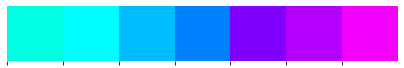

In [ ]:
# Regular Libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from tabulate import tabulate
import missingno as msno 
from IPython.display import display_html
from PIL import Image
import gc
import cv2
from scipy.stats import pearsonr
import tqdm

import pydicom # for DICOM images
from skimage.transform import resize
import copy
import re

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Color Palette
custom_colors = ['#00FFE2', '#00FDFF', '#00BCFF', '#0082FF', '#8000FF', '#B300FF', '#F400FF']
sns.palplot(sns.color_palette(custom_colors))

# Set Style
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

# Set tick size
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

In [ ]:
# Rapids Imports
import cudf
import cupy # CuPy is an open-source array library accelerated with NVIDIA CUDA.

from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster

cluster = LocalCUDACluster()
client = Client(cluster)
client

/usr/local/lib/python3.6/site-packages/distributed/client.py:1129: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| numpy   | 1.18.5 | 1.18.5    | 1.19.4  |
| tornado | 5.1.1  | 5.1.1     | 6.1     |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Client Scheduler: tcp://127.0.0.1:42743 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 1 Memory: 13.65 GB


In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " | Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.3 GB  | Proc size: 484.3 MB
GPU RAM Free: 14871MB | Used: 208MB | Util   1% | Total     15079MB


In [ ]:
printm()

Gen RAM Free: 12.3 GB  | Proc size: 484.3 MB
GPU RAM Free: 14871MB | Used: 208MB | Util   1% | Total     15079MB


# **EDA**

## **Common**

In [ ]:
def distplot_features(df, feature, title, color = custom_colors[4], categorical=True):
    '''Takes a column from the GPU dataframe and plots the distribution (after count).'''
    
    if categorical:
        values = cupy.asnumpy(df[feature].value_counts().values)
    else:
        values = cupy.asnumpy(df[feature].values)
        
    print('Mean: {:,}'.format(np.mean(values)), "\n"
          'Median: {:,}'.format(np.median(values)), "\n",
          'Std: {:,}'.format(np.std(values)), "\n",
          'Max: {:,}'.format(np.max(values)))

    
    plt.figure(figsize = (18, 5))
    
    if categorical:
        sns.distplot(values, hist=False, color = color, kde_kws = {'lw':3})
    else:
        # To speed up the process
        sns.distplot(values[::250000], hist=False, color = color, kde_kws = {'lw':3})
    
    plt.title(title, fontsize=15)
    plt.show();
    
    del values
    gc.collect()

In [ ]:
def barplot_features(df, feature, title, palette = custom_colors[2:]):
    '''Takes the numerical columns (with less than 10 categories) and plots the barplot.'''
    
    # We need to extract both the name of the category and the no. of appearences
    index = cupy.asnumpy(df[feature].value_counts().reset_index()["index"].values)
    values = cupy.asnumpy(df[feature].value_counts().reset_index()[feature].values) 

    plt.figure(figsize = (18, 3))
    sns.barplot(x = index, y = values, palette = custom_colors[2:])
    plt.title(title, fontsize=15)
    plt.show();
    
    del index, values
    gc.collect()

## **Train**

In [ ]:
%%time

# Read in data
dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "boolean",
    "task_container_id": "int16",
    "user_answer": "int8",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32", 
    "prior_question_had_explanation": "int8"
}

train = cudf.read_parquet('data/train.parquet', dtype=dtypes)


CPU times: user 1.83 s, sys: 1.08 s, total: 2.91 s
Wall time: 32.7 s


In [ ]:
# Data Information
print("Rows: {:,}".format(len(train)), "\n" +
      "Columns: {}".format(len(train.columns)))

# Find Missing Data if any
total = len(train)

for column in train.columns:
    if train[column].isna().sum() != 0:
        print("{} has: {:,} ({:.2}%) missing values.".format(column, train[column].isna().sum(), 
                                                             (train[column].isna().sum()/total)*100))
        
        
# Fill in missing values with "-1"
train["prior_question_elapsed_time"] = train["prior_question_elapsed_time"].fillna(-1)
train["prior_question_had_explanation"] = train["prior_question_had_explanation"].fillna(-1)

train.head()

Rows: 101,230,332 
Columns: 9
prior_question_elapsed_time has: 2,351,538 (2.3%) missing values.
prior_question_had_explanation has: 392,506 (0.39%) missing values.


,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,115,5692,False,1,3,1,-1.0,-1
1,56943,115,5716,False,2,2,1,37000.0,0
2,118363,115,128,False,0,0,1,55000.0,0
3,131167,115,7860,False,3,0,1,19000.0,0
4,137965,115,7922,False,4,1,1,11000.0,0


Mean: 7,703,643,654.326523 
Median: 2,674,233,764.5 
 Std: 11,592,655,251.266787 
 Max: 87,425,772,049


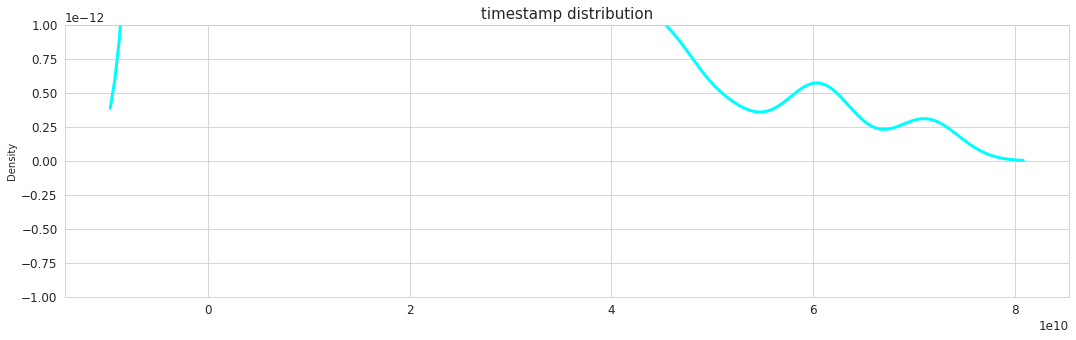

Mean: 24,833.234375 
Median: 21,000.0 
 Std: 20,083.599609375 
 Max: 300,000.0


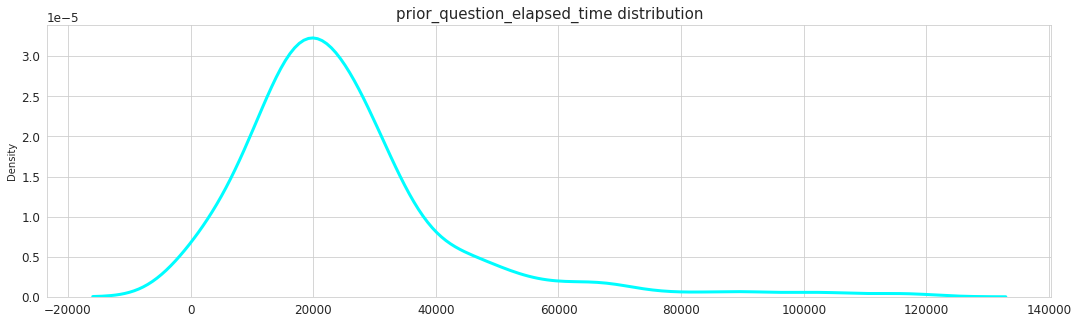

In [ ]:
numerical_features = ['timestamp', 'prior_question_elapsed_time']

for feature in numerical_features:
    distplot_features(train, feature=feature, title = feature + " distribution", color = custom_colors[1], categorical=False)

Mean: 257.1542971528441 
Median: 41.0 
 Std: 747.5499849153472 
 Max: 17,917


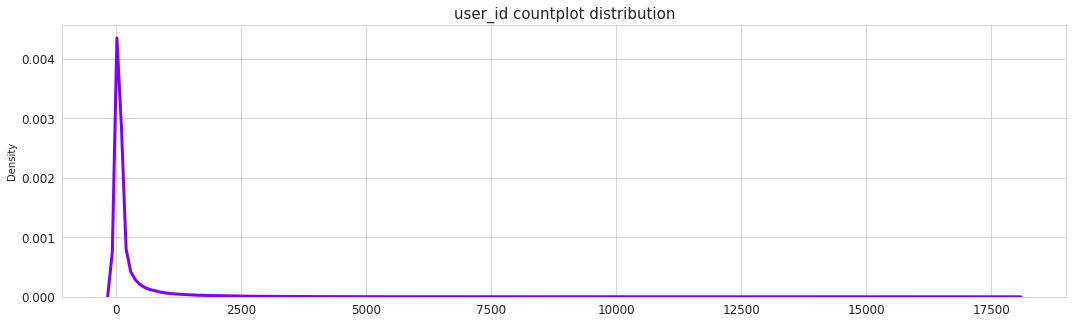

Mean: 7,345.111885067479 
Median: 4,728.5 
 Std: 11,414.598139586467 
 Max: 213,605


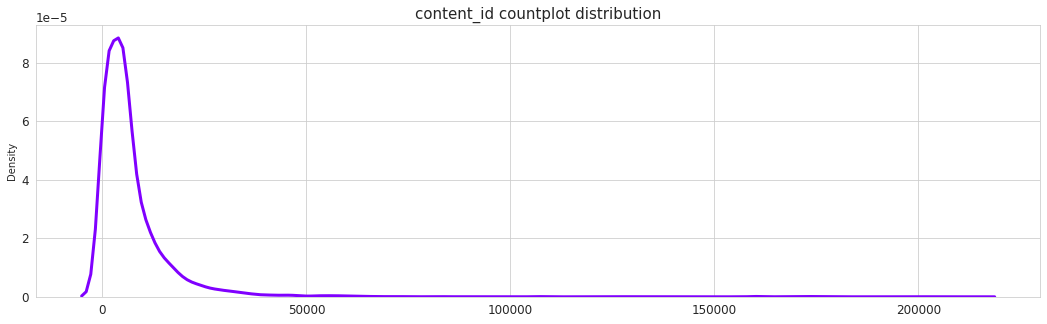

Mean: 10,123.0332 
Median: 1,318.0 
 Std: 32,867.07506393743 
 Max: 804,285


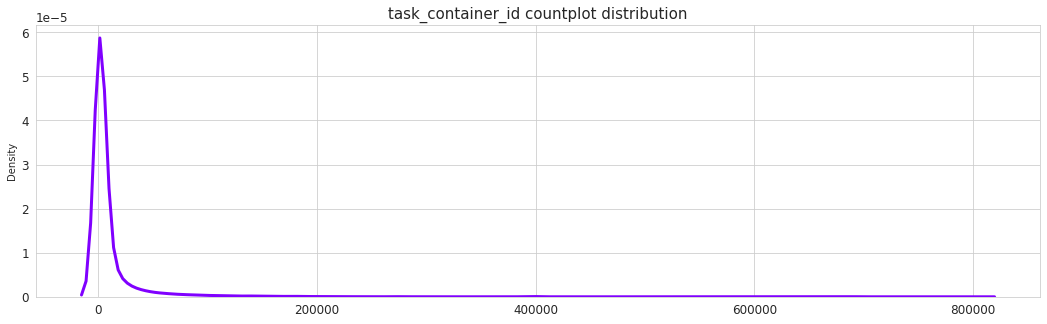

In [ ]:
categorical_features = ['user_id', 'content_id', 'task_container_id']

for feature in categorical_features:
    distplot_features(train, feature=feature, title = feature + " countplot distribution", color = custom_colors[4], categorical=True)

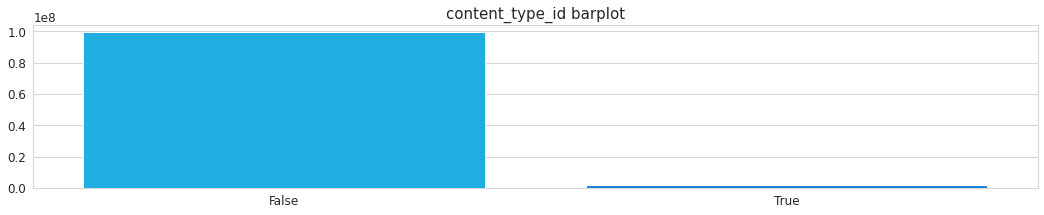

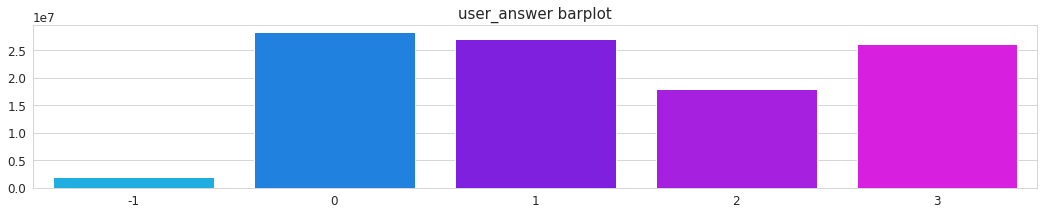

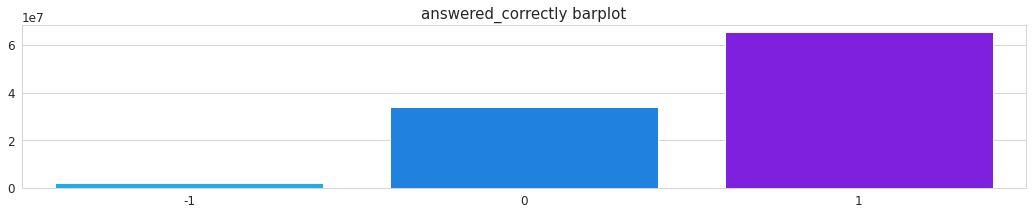

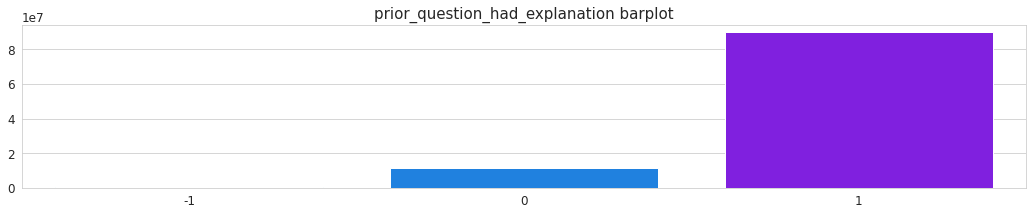

In [ ]:
categorical_for_bar = ['content_type_id', 'user_answer', 
                       'answered_correctly', 'prior_question_had_explanation']

for feature in categorical_for_bar:
    barplot_features(train, feature=feature, title = feature + " barplot")

In [ ]:
# Total rows we started with
total = len(train)
feature = "timestamp"

# Compute Outliers
Q1 = cupy.percentile(train[feature].values, q = 25).item()
Q3 = cupy.percentile(train[feature].values, q = 75).item()
IQR = Q3 - Q1

# We'll look only at the upper interval outliers
outlier_boundry = Q3 + 1.5*IQR

print('Timestamp: around {:.2}% of the data would be erased.'.format(len(train[train[feature] >= outlier_boundry])/total * 100), 
      "\n"+
      'The outlier boundry is {:,}, which means {:,.5} hrs, which means {:,.5} days.'.format(outlier_boundry, (outlier_boundry / 3.6e+6),
                                                                                       (outlier_boundry / 3.6e+6)/24))

gc.collect()

Timestamp: around 9.4% of the data would be erased. 
The outlier boundry is 24,024,861,068.375, which means 6,673.6 hrs, which means 278.07 days.


0

In [ ]:
# Select ids to erase
ids_to_erase = train["user_id"].value_counts().reset_index()[train["user_id"].value_counts().reset_index()["user_id"] < 5]["index"].values

# Erase the ids
new_train = train[~train['user_id'].isin(ids_to_erase)]

print("We erased {} rows meaning {:.3}% of all data.".format(len(train)-len(new_train), (1 - len(new_train)/len(train))*100))
del ids_to_erase

We erased 599 rows meaning 0.000592% of all data.


In [ ]:
# Count how many times the user answered correctly out of all available times
user_performance = train.groupby("user_id").agg({ 'answered_correctly': ['count', 'sum'] }).reset_index()
user_performance.columns = ["user_id", "total_count", "correct_count"]
user_performance["performance"] = user_performance["correct_count"] / user_performance["total_count"]

# Create intervals for number of appearences
# between 0 and 1000, 1000 and 2500 and 2500+
def condition(x):
    if x <= 1000:
        return 0
    elif (x > 1000) & (x <= 2500):
        return 1
    else:
        return 2
    
user_performance["total_interval"] = user_performance["total_count"].applymap(condition)

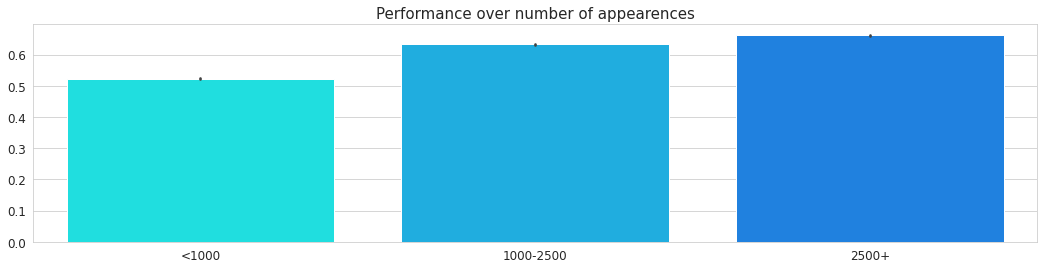

In [ ]:
# Convert to numpy arrays (so we can plot)
x = cupy.asnumpy(user_performance["total_interval"].values)
y = cupy.asnumpy(user_performance["performance"].values)

# Plot
plt.figure(figsize = (18, 4))
sns.barplot(x = x, y = y, palette = custom_colors[1:])
plt.title("Performance over number of appearences", fontsize = 15)
plt.xticks([0, 1, 2], ['<1000', '1000-2500', '2500+']);


In [ ]:
# Checkpoint: save to .parquet
new_train.to_parquet('new_train.parquet')

In [ ]:
# Clean the environment
del train, new_train
gc.collect()

59

## **Questions**

In [ ]:
questions = cudf.read_csv('data/questions.csv')

# Data Information
print("Rows: {:,}".format(len(questions)), "\n" +
      "Columns: {}".format(len(questions.columns)))

# Find Missing Data if any
total = len(questions)

for column in questions.columns:
    if questions[column].isna().sum() != 0:
        print("{} has: {:,} ({:.2}%) missing values.".format(column, questions[column].isna().sum(), 
                                                             (questions[column].isna().sum()/total)*100))
        
        
# Fill in missing values with "-1"
questions["tags"] = questions["tags"].fillna(-1)

questions.head()

Rows: 13,523 
Columns: 5
tags has: 1 (0.0074%) missing values.


,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [ ]:
# ----- question_id -----

# The table contains an equal number of IDs for each question
print('There is a total of {:,} IDs.'.format(len(questions['question_id'].value_counts())), "\n")

# ----- bundle_id -----
print('There are {:,} unique bundle IDs.'.format(questions['bundle_id'].nunique()))

There is a total of 13,523 IDs. 

There are 9,765 unique bundle IDs.


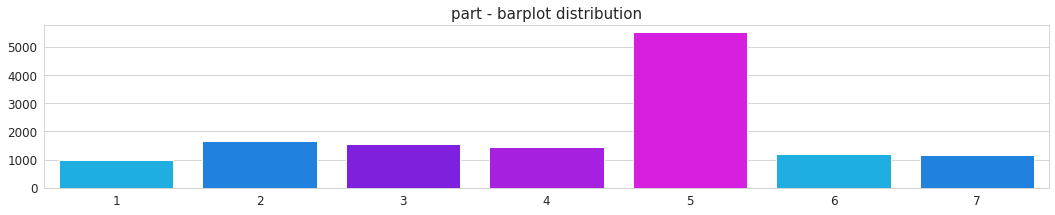

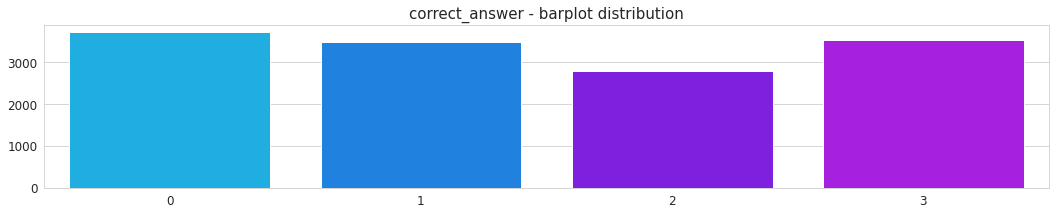

In [ ]:
# ----- part & correct_answer -----

for feature in ['part', 'correct_answer']:
    barplot_features(questions, feature=feature, title=feature + " - barplot distribution")

Mean: 8.89671052631579 
Median: 2.0 
 Std: 36.950204610506695 
 Max: 738


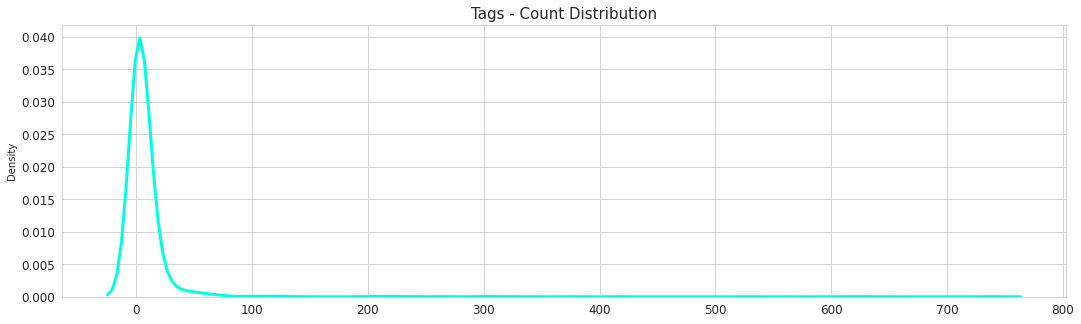

In [ ]:
# ----- tags -----
distplot_features(questions, 'tags', title = "Tags - Count Distribution", color = custom_colors[0], categorical=True)

In [ ]:
# Checkpoint: save to parquet
questions.to_parquet('questions.parquet')

In [ ]:
del questions
gc.collect()

0

## **Lectures**

In [ ]:
lectures = cudf.read_csv('data/lectures.csv')

# Encode 'type_of' column
lectures.type_of,codes = lectures['type_of'].factorize()

# Data Information
print("Rows: {:,}".format(len(lectures)), "\n" +
      "Columns: {}".format(len(lectures.columns)))
lectures.head()

Rows: 418 
Columns: 4


,lecture_id,tag,part,type_of
0,89,159,5,0
1,100,70,1,0
2,185,45,6,0
3,192,79,5,2
4,317,156,5,2


In [ ]:
# ----- lecture_id -----
# The table contains an equal number of IDs for each question
print('There is a total of {:,} IDs.'.format(len(lectures['lecture_id'].value_counts())), "\n")

# There are 151 unique tags
print('There are a total of {:,} unique tags IDs.'.format(len(lectures['tag'].value_counts())))

There is a total of 418 IDs. 

There are a total of 151 unique tags IDs.


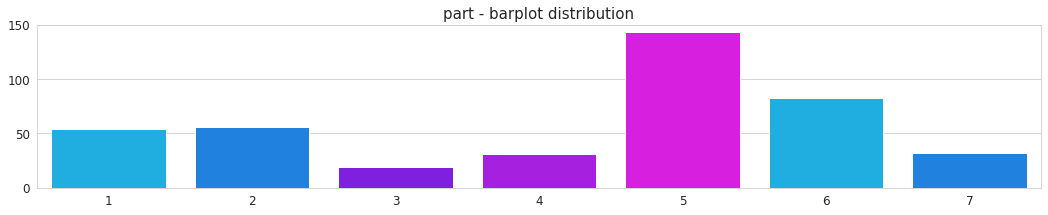

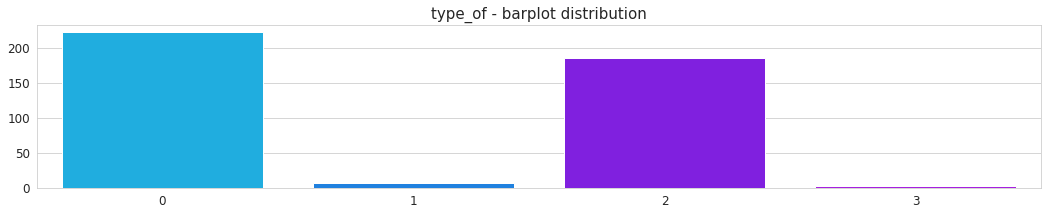

In [ ]:
for feature in ['part', 'type_of']:
    barplot_features(lectures, feature=feature, title=feature + " - barplot distribution")

# **Process Data**

In [ ]:
!/opt/bin/nvidia-smi
!ps -aux|grep python

In [ ]:
!kill -9 15627  

/bin/bash: line 0: kill: (15627) - No such process


In [ ]:
%%time
# Import the data
train = cudf.read_parquet("new_train.parquet")
questions = cudf.read_parquet("questions.parquet")

# Lectures we won't load, as we are not supposed to predict for these rows

CPU times: user 554 ms, sys: 342 ms, total: 896 ms
Wall time: 883 ms


In [ ]:
%%time
# Let's exclude all observations where (content_type_id = 1) & (answered_correctly = -1)
train = train[train['content_type_id'] != 1]
train = train[train['answered_correctly'] != -1].reset_index(drop=True)

CPU times: user 184 ms, sys: 168 ms, total: 352 ms
Wall time: 345 ms


In [ ]:
import random 
import time

def random_timestamp_sort(df):
  max_timestamp_u = df[['user_id','timestamp']].groupby('user_id').agg('max').reset_index()

  max_timestamp_u.columns = ['user_id', 'max_time_stamp']
  MAX_TIME_STAMP = max_timestamp_u['max_time_stamp'].max()


  interval = max_timestamp_u['max_time_stamp'] - MAX_TIME_STAMP
  interval *= -1
  multiplier = cudf.Series(np.random.rand(len(max_timestamp_u)))
  random_timestamp = interval * multiplier
  
  max_timestamp_u['rand_time_stamp'] = random_timestamp.floor()

  return max_timestamp_u[['user_id', 'rand_time_stamp']]

In [ ]:
%%time
# Split data into train data & feature engineering data (to use for past performance)
# Timestamp is in descending order - meaning that the last 10% observations have
# the biggest chance of having had some performance recorded before
# so looking at the performance in the past we'll try to predict the performance now

random_timestamp = random_timestamp_sort(train)
train = train.merge(random_timestamp, on='user_id', how='left')
train['virtual_time_stamp'] = train['timestamp'] + train['rand_time_stamp']
train = train.sort_values('virtual_time_stamp').reset_index(drop=True)
train.to_parquet('train_virtual_timestamp.parquet')

CPU times: user 2.48 s, sys: 3.5 s, total: 5.98 s
Wall time: 19.6 s


In [ ]:
del train
del random_timestamp
gc.collect()

NameError: ignored

In [ ]:
%%time
# Import the data
train = cudf.read_parquet("train_virtual_timestamp.parquet")
questions = cudf.read_parquet("questions.parquet")

# Lectures we won't load, as we are not supposed to predict for these rows

train_percent = 0.1
features, test = train.iloc[ : int(len(train)*(1-train_percent))], train.iloc[int(len(train)*(1-train_percent)) : ]

CPU times: user 845 ms, sys: 555 ms, total: 1.4 s
Wall time: 1.37 s


In [ ]:
%%time
# --- STUDENT ANSWERS ---
# Group by student
user_answers = features[features['answered_correctly']!=-1].\
                            groupby('user_id').\
                            agg({'answered_correctly': ['sum', 'mean', 'min', 
                                                        'max', 'count', 'median', 
                                                        'std', 'var']}).\
                            reset_index()

user_answers.columns = ['user_id', 'user_sum', 'user_mean', 'user_min', 'user_max', 
                        'user_count', 'user_median', 'user_std', 'user_var']

# --- CONTENT ID ANSWERS ---
# Group by content
content_answers = features[features['answered_correctly']!=-1].\
                            groupby('content_id').\
                            agg({'answered_correctly': ['sum', 'mean', 'min', 
                                                        'max', 'count', 'median', 
                                                        'std', 'var']}).\
                            reset_index()

content_answers.columns = ['content_id', 'content_sum', 'content_mean', 'content_min', 
                           'content_max', 'content_count', 'content_median', 'content_std', 
                           'content_var']

CPU times: user 2.64 s, sys: 2.42 s, total: 5.05 s
Wall time: 4.98 s


In [ ]:
user_answers.to_parquet('user_answers.parquet')
content_answers.to_parquet('content_answers.parquet')

In [ ]:
!zip -r features.zip features/*

  adding: features/content_answers.parquet (deflated 17%)
  adding: features/lectures.parquet (deflated 39%)
  adding: features/questions.parquet (deflated 65%)
  adding: features/train_virtual_timestamp.parquet (deflated 23%)
  adding: features/user_answers.parquet (deflated 13%)


In [ ]:
!cp features.zip 'gdrive/My Drive/kaggle'

# **Model**

In [ ]:
def make_cum_features_names(props):
  props_string = '_and_'.join(props)
  return f'count_by_{props_string}', f'proportion_by_{props_string}'

def make_static_features_names(props):
  props_string = '_and_'.join(props)
  return f'static_count_by_{props_string}', f'static_proportion_by_{props_string}'

def make_feature_group_name(props):
  if np.isscalar(props):
    return props
  return '|'.join([str(prop) for prop in props])

In [ ]:
class ProportionFeatureAppender:
  def __init__(self, feature_props = [], feature_dict = {}, name_prefix=''):
    self.feature_props = feature_props
    self.feature_dict = feature_dict
    self.name_prefix = ''
    if not self.name_prefix == '':
      self.name_prefix += '_'
    
  def apply_features(self, df, update = True):
    for props in self.feature_props:
      feature_name = make_group_name(props) 
      if feature_name not in self.feature_dict:
        self.feature_dict[feature_name] = {}
      features_dict = cum_features_dict[feature_name]
      count_name, proportion_name = self.make_features_names(props)
      df[[count_name, proportion_name]] = df.groupby(props).apply(apply_group_cum, features_dict = features_dict) 
  
    return df

  def update_features(self, df):

  def make_features_names(self, props):
    props_string = '_and_'.join(props)
    return f'{self.name_prefix}count_by_{props_string}', f'{self.name_prefix}proportion_by_{props_string}'

  def make_group_name(props):
    if np.isscalar(props):
      return props
    return '|'.join([str(prop) for prop in props])

In [ ]:
import time

def apply_group_cum(group, features_dict):
    group_name = make_feature_group_name(group.name)
    
    if group_name not in features_dict:
      features_dict[group_name] = {
          'count': 0,
          'proportion': 0
      }
    
    last_count = features_dict[group_name]['count']
    last_proportion = features_dict[group_name]['proportion']
    
    count = np.arange(len(group)) + last_count
    proportion = (group['answered_correctly'].cumsum() + last_proportion * last_count) / count

    features_dict[group_name] = {
        'count': count[-1],
        'proportion': (group['answered_correctly'][-1] + last_proportion * last_count) / count
    }

    return pd.DataFrame({1: count, 2: proportion}, index = group.index)

def add_cum_features(df, cum_features_props, cum_features_dict, update = True):
  for props in cum_features_props:
    feature_name = make_feature_group_name(props) 
    if feature_name not in cum_features_dict:
      cum_features_dict[feature_name] = {}
    features_dict = cum_features_dict[feature_name]
    count_name, proportion_name = make_cum_features_names(props)
    df[[count_name, proportion_name]] = df.groupby(props).apply(apply_group_cum, features_dict = features_dict) 
  
  return df, cum_features_dict

In [ ]:
def apply_group_static(group, features_dict, update):
    group_name = make_feature_group_name(group.name)

    if group_name not in features_dict:
      features_dict[group_name] = {
          'count': 1,
          'proportion': 0
      }
    group_features = features_dict[group_name]
    last_count = group_features['count']
    last_proportion = group_features['proportion']
    
    if update:
      # if update is True modify values with new information
      count = len(group) + last_count
      proportion = (group['answered_correctly'].sum() + last_proportion * last_count) / count

      features_dict[group_name] = {
          'count': count,
          'proportion': proportion
      }
    else:
      # if update is False fill value with global averages(don't use new information)
      counts = [features_dict[key]['count'] for key in features_dict]
      count = sum(counts) / len(counts)
      sums = [features_dict[key]['count'] * features_dict[key]['proportion'] for key in features_dict]
      proportion = sum(sums) / sum(counts)

    return pd.DataFrame({1:np.full(len(group), count), 2:np.full(len(group), proportion)}, index = group.index)


def add_static_features(df, static_features_props, static_features_dict, update = True):
  for props in static_features_props:
    feature_name = make_feature_group_name(props)
    if feature_name not in static_features_dict:
      static_features_dict[feature_name] = {}
    features_dict = static_features_dict[feature_name]
    count_name, proportion_name = make_static_features_names(props)

    df[[count_name, proportion_name]] = df.groupby(props).apply(apply_group_static, features_dict = features_dict, update = update) 
  return df, static_features_dict

In [ ]:
cum_features_props = [['user_id'], ['user_id', 'part']]
cum_features_dict = {}

questions_train_df, cum_features_dict = add_cum_features(questions_train_df, cum_features_props, cum_features_dict)

In [ ]:
static_features_props = [['content_id']]
static_features_dict = {}

questions_train_df, static_features_dict = add_static_features(questions_train_df, static_features_props, static_features_dict, update = True)


In [ ]:
questions_train_df[['content_id','static_count_by_content_id', 'static_proportion_by_content_id']]

,content_id,static_count_by_content_id,static_proportion_by_content_id
0,5692,5,0.800000
1,5716,3,0.666667
2,128,3,0.666667
3,7860,3,0.666667
4,7922,3,0.666667
...,...,...,...
9758,1124,3,0.333333
9759,810,3,0.666667
9760,1245,4,0.250000
9761,711,3,0.666667


In [ ]:
def select_features(df, cum_features_props, static_features_props, elapsed_time_mean = None):

  cum_names = [make_cum_features_names(props) for props in cum_features_props]
  static_names = [make_static_features_names(props) for props in static_features_props]

  features_names = []
  for names in cum_names + static_names:
      features_names += names

  features_df = df[[
                            'prior_question_elapsed_time', 
                            'prior_question_had_explanation', 
                            'part', 
                            *features_names
                            ]]
  
  return features_df,  df['answered_correctly'].reset_index(drop=True)

In [ ]:
features, Y = select_features(questions_train_df)

In [ ]:
from sklearn.preprocessing import MaxAbsScaler

def scale(features, Y, scaler = None):
  if scaler == None:
    scaler = MaxAbsScaler()
    scaler.fit(features)
  scaled_data = scaler.transform(features)
  X = pd.DataFrame(scaled_data, columns=features.columns)
  return X, Y, scaler

In [ ]:
X,Y,scaler = scale(features, Y)

In [ ]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

def train_model(X,Y):

  lgb_train = lgb.Dataset(X, Y)

  params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
    'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
    'num_leaves': trial.suggest_int('num_leaves', 2, 256),
    'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
    'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
    'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
  }

  model = lgb.train(
                      params, 
                      lgb_train,
                      valid_sets=[lgb_train, lgb_train],
                      verbose_eval=100,
                      num_boost_round=10000,
                      early_stopping_rounds=10
                  )

  return model

In [ ]:
import lightgbm as lgb
import optuna
from sklearn.metrics import roc_auc_score

def train_model_optimize_params(data):
    X_train, Y_train, X_test, Y_test = random_split(data)
    dtrain = lgb.Dataset(X_train, Y_train)
    dval = lgb.Dataset(X_test, Y_test)
 
    def objective(trial):
      params = {
          'objective': 'binary',
          'metric': 'binary_logloss',
          'verbosity': -1,
          'boosting_type': 'gbdt',
          'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
          'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
          'num_leaves': trial.suggest_int('num_leaves', 2, 256),
          'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
          'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
          'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
          'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
      }

      gbm = lgb.train(params, dtrain, early_stopping_rounds = 100, num_boost_round=1000)
      accuracy = roc_auc_score(Y_test, gbm.predict(X_test))
      print(accuracy)
      return accuracy

    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial), n_trials=100)

    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)

    return study.best_trial.params
    

# **Cross Validation Save**

In [ ]:
import pandas as pd
NUM_OF_ROWS = 10_000_000
train = pd.read_csv('train.csv', nrows=NUM_OF_ROWS)

In [ ]:
import random 

max_timestamp_u = train[['user_id','timestamp']].groupby(['user_id']).agg(['max']).reset_index()
max_timestamp_u.columns = ['user_id', 'max_time_stamp']
MAX_TIME_STAMP = max_timestamp_u.max_time_stamp.max()

def rand_time(max_time_stamp):
    interval = MAX_TIME_STAMP - max_time_stamp
    rand_time_stamp = random.randint(0,interval)
    return rand_time_stamp

max_timestamp_u['rand_time_stamp'] = max_timestamp_u.max_time_stamp.apply(rand_time)
train = train.merge(max_timestamp_u, on='user_id', how='left')
train['viretual_time_stamp'] = train.timestamp + train['rand_time_stamp']

train = train.sort_values(['viretual_time_stamp', 'row_id']).reset_index(drop=True)

In [ ]:
!mkdir cv

In [ ]:
import random
from pathlib import Path

folds = 5
val_size = len(train) // ( 10 * (folds-1))

for cv in range(folds):
    curr = time.time()
    valid = train[-val_size:]
    train = train[:-val_size]
    # check new users and new contents
    new_users = len(valid[~valid.user_id.isin(train.user_id)].user_id.unique())
    valid_question = valid[valid.content_type_id == 0]
    train_question = train[train.content_type_id == 0]
    new_contents = len(valid_question[~valid_question.content_id.isin(train_question.content_id)].content_id.unique())    
    print(f'cv{cv} {train_question.answered_correctly.mean():.3f} {valid_question.answered_correctly.mean():.3f} {new_users} {new_contents}')
    valid.to_pickle(f'cv/cv{cv+1}_valid.pickle')
    train.to_pickle(f'cv/cv{cv+1}_train.pickle')
    print(f'pickled in: {time.time() - curr}')
    curr = time.time()

cv0 0.659 0.652 1430 1
pickled in: 4.8966639041900635
cv1 0.659 0.655 1027 0
pickled in: 13.185844421386719
cv2 0.659 0.662 950 0
pickled in: 22.352181911468506
cv3 0.659 0.662 963 0
pickled in: 23.7846417427063
cv4 0.659 0.661 942 0
pickled in: 20.55452036857605


# **Add Features**

In [ ]:
!ls 

build					     __init__.py    sample_data
competition.cpython-37m-x86_64-linux-gnu.so  kaggle.json    train.csv
cv					     lectures.csv   train.csv.zip
example_sample_submission.csv		     LightGBM
example_test.csv			     questions.csv


In [ ]:
import pandas as pd

questions = pd.read_csv('questions.csv')
lectures = pd.read_csv('lectures.csv')
questions.rename(columns = {'question_id': 'content_id'}, inplace = True)

lectures.rename(columns = {'lecture_id': 'content_id'}, inplace = True)

In [ ]:
import time
folds = 5

started = False
df = None
answers = None 

for cv in range(folds):
  
  print(f'-------------------------  fold - {cv+1}   --------------------------------')
  init_time = time.time()
  train = pd.read_pickle(f'cv/cv{cv+1}_train.pickle')
  valid = pd.read_pickle(f'cv/cv{cv+1}_valid.pickle')

  cum_features_props = [['user_id'], ['user_id', 'part']]
  cum_features_dict = {}
  
  static_features_props = [['content_id']]
  static_features_dict = {}
  
  df_train, _ = split_merge_data(train, questions, lectures)

  # feature selection and updates
  curr = time.time()
  df_train, cum_features_dict = add_cum_features(df_train, cum_features_props, cum_features_dict)  
  print(f'added train cum features in: {time.time() - curr}')
  curr = time.time()
  
  df_train, static_features_dict = add_static_features(df_train, static_features_props, static_features_dict)
  print(f'added train static features in: {time.time() - curr}')
  curr = time.time()
  
  features_train, Y_train = select_features(df_train, cum_features_props, static_features_props)

  elapsed_time_count = features_train.prior_question_elapsed_time.dropna().count()
  elapsed_time_mean = features_train.prior_question_elapsed_time.dropna().mean()
  
  features_train = features_train.fillna(value = {
      'prior_question_had_explanation': False,
      'prior_question_elapsed_time': elapsed_time_mean
      })

  if not started:
    df = features_train
    answers = Y_train
  
  X_train,Y_train, scaler = scale(features_train, Y_train)
  print(f'selected and cleaned train features in: {time.time() - curr}')
  curr = time.time()
  
  X_train.to_pickle(f'cv/cv{cv+1}_X_train.pickle')
  print(f'saved X_train in: {time.time() - curr}')
  curr = time.time()
  
  Y_train.to_pickle(f'cv/cv{cv+1}_Y_train.pickle')
  print(f'saved Y_train in: {time.time() - curr}')
  curr = time.time()
  
  df_valid, _ = split_merge_data(valid, questions, lectures)

  # feature selection and updates
  curr = time.time()
  df_valid, cum_features_dict = add_cum_features(df_valid, cum_features_props, cum_features_dict)
  print(f'added valid cum features in: {time.time() - curr}')
  curr = time.time()
  
  df_valid, static_features_dict = add_static_features(df_valid, static_features_props, static_features_dict)
  print(f'added valid static features in: {time.time() - curr}')
  curr = time.time()
  
  features_valid, Y_valid = select_features(df_valid, cum_features_props, static_features_props)

  elapsed_time_count += features_valid.prior_question_elapsed_time.dropna().count()
  elapsed_time_mean = (features_valid.prior_question_elapsed_time.dropna().sum() + elapsed_time_mean * (elapsed_time_count - features_valid.prior_question_elapsed_time.dropna().count())) / elapsed_time_count
  
  features_valid = features_valid.fillna(value = {
      'prior_question_had_explanation': False,
      'prior_question_elapsed_time': elapsed_time_mean
      })

  X_valid, Y_valid, scaler = scale(features_valid, Y_valid)

  print(f'selected and cleaned valid features in: {time.time() - curr}')
  curr = time.time()
  

  X_valid.to_pickle(f'cv/cv{cv+1}_X_valid.pickle')
  print(f'saved X_valid in: {time.time() - curr}')
  curr = time.time()
  
  Y_valid.to_pickle(f'cv/cv{cv+1}_Y_valid.pickle')
  print(f'saved Y_valid in: {time.time() - curr}')

  print(f'total time: {time.time() - init_time}')
  init_time = time.time()
  

-------------------------  fold - 1   --------------------------------
added train cum features in: 256.89497923851013
added train static features in: 18.59993863105774
['count_by_user_id', 'proportion_by_user_id', 'count_by_user_id_and_part', 'proportion_by_user_id_and_part', 'static_count_by_content_id', 'static_proportion_by_content_id']
selected and cleaned train features in: 17.37358045578003
saved X_train in: 2.950249433517456
saved Y_train in: 0.24951791763305664
added valid cum features in: 13.24678111076355
added valid static features in: 11.770996809005737
['count_by_user_id', 'proportion_by_user_id', 'count_by_user_id_and_part', 'proportion_by_user_id_and_part', 'static_count_by_content_id', 'static_proportion_by_content_id']
selected and cleaned valid features in: 0.30914878845214844
saved X_valid in: 0.02549457550048828
saved Y_valid in: 0.00347900390625
total time: 358.03234696388245
-------------------------  fold - 2   --------------------------------
added train cum fe

# **Cross Validation Train**

In [ ]:
import pandas as pd
import lightgbm as lgb

folds = 1

aucs= []

for cv in range(folds):
  X_train = pd.read_pickle(f'cv/cv{cv+1}_X_train.pickle')
  Y_train = pd.read_pickle(f'cv/cv{cv+1}_Y_train.pickle')
  
  X_valid = pd.read_pickle(f'cv/cv{cv+1}_X_valid.pickle')
  Y_valid = pd.read_pickle(f'cv/cv{cv+1}_Y_valid.pickle')

  model = train_model_optimize_params(X_train, Y_train, X_valid, Y_valid)
  lgb.plot_importance(model)

TypeError: ignored

In [ ]:
aucs

[0.7199600895824313,
 0.6876805935759774,
 0.6503452857585772,
 0.6747907469506821,
 0.6956109446452583]

In [ ]:
!zip -r /content/cv.zip /content/cv

  adding: content/cv/ (stored 0%)
  adding: content/cv/cv3_train.pickle (deflated 82%)
  adding: content/cv/cv2_X_train.pickle (deflated 72%)
  adding: content/cv/cv4_Y_train.pickle (deflated 97%)
  adding: content/cv/cv1_Y_train.pickle (deflated 97%)
  adding: content/cv/cv2_X_valid.pickle (deflated 71%)
  adding: content/cv/cv1_Y_valid.pickle (deflated 96%)
  adding: content/cv/cv4_X_valid.pickle (deflated 72%)
  adding: content/cv/cv1_X_train.pickle (deflated 72%)
  adding: content/cv/cv5_Y_train.pickle (deflated 97%)
  adding: content/cv/cv3_valid.pickle (deflated 82%)
  adding: content/cv/cv5_valid.pickle (deflated 82%)
  adding: content/cv/cv2_Y_train.pickle (deflated 97%)
  adding: content/cv/cv3_Y_valid.pickle (deflated 96%)
  adding: content/cv/cv5_X_valid.pickle (deflated 71%)
  adding: content/cv/cv1_valid.pickle (deflated 83%)
  adding: content/cv/cv1_X_valid.pickle (deflated 72%)
  adding: content/cv/cv4_X_train.pickle (deflated 72%)
  adding: content/cv/cv3_X_valid.pickle

# **Upload File**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
!cp cv.zip '/content/gdrive/My Drive/kaggle'
!ls -lt '/content/gdrive/My Drive/kaggle' 

total 2356570
-rw------- 1 root root 1773248237 Nov 15 19:35  cv.zip
drwx------ 2 root root       4096 Nov 10 22:24 'Colab Notebooks'
-rw------- 1 root root        151 Sep  3 08:18  dns-records.gsheet
drwx------ 2 root root       4096 Jun 13 10:55  books
-rw------- 1 root root     314159 May 29 13:20 'Assignment 10.pdf'
-rw------- 1 root root    3963760 May 29 13:20  PL-Stovyklos-Programa-CLOSE.pptx
-rw------- 1 root root       9428 May 29 13:20  SAT7.xlsx
-rw------- 1 root root      51245 May 12  2020  Prašymas_baigiamojo_darbo_temos_pasirinkimui_kai_renkasi_temą_pats_studentas.pdf
-rw------- 1 root root        151 Mar 27  2020 '„Tomo Rasimavičiaus “Practice test 7” (ML1 ST3)“ kopija.gdoc'
-rw------- 1 root root        151 Mar 27  2020 '„Tomo Rasimavičiaus “Practice test 6” (ML2 ST5)“ kopija.gdoc'
-rw------- 1 root root        151 Mar 27  2020 '„Tomo Rasimavičiaus “Practice test 5” (ML1 ST1)“ kopija.gdoc'
-rw------- 1 root root        151 Mar 27  2020 '„Tomo Rasimavičiaus “Pract